## Higgs Effective Field Theory (HEFT) Study: Training
> Created: Feb 12, 2024 Nicola de Filippis, Kurtis Johnson, Harrison B. Prosper, Ryne Starnes<br>

### Introduction

In this notebook, we model the HEFT di-Higgs cross section[1] (per 15 GeV in the di-Higgs mass, $m_{hh}$) in which the 15 GeV bin size is mapped to a dimensionless value of 0.01. The HEFT parameter space is defined by the 5 parameters $\theta = c_{hhh}, c_{t}, c_{tt}, c_{ggh}, c_{gghh}$. 

\begin{align}
    \sigma(m_{gg}, \theta) & = \boldsymbol{c}^T(\theta) \cdot \boldsymbol{a}(m_{hh}), 
\end{align}

for the cross section per bin, $\sigma$, where

\begin{align}
    \boldsymbol{c}^T(\theta) & = (c_{t}^4, 
             c_{tt}^2,
             c_{t}^2 c_{hhh}^2,
             c_{ggh}^2 c_{hhh}^2,\nonumber\\
             &\quad\,\,\,\,c_{gghh}^2, 
             c_{tt} c_{t}^2,             
             c_{hhh} c_{t}^3,  \nonumber\\
             &\quad\,\,\,\,
             c_{t} c_{hhh} c_{tt},
             c_{ggh} c_{hhh} c_{tt}, c_{tt} c_{gghh},\nonumber\\
             &\quad\,\,\,\,
             c_{ggh} c_{hhh} c_{t}^2, 
             c_{gghh} c_{t}^2, \nonumber\\
             &\quad\,\,\,\, 
             c_{hhh}^2 c_{ggh} c_{t}, c_{gghh} c_{t} c_{hhh}, \nonumber\\
             &\quad\,\,\,\, 
             c_{ggh} c_{gghh} c_{hhh}, 
             c_{t}^3 c_{ggh},\nonumber\\
             &\quad\,\,\,\,
             c_{t} c_{tt} c_{ggh}, c_{t} c_{ggh}^2 c_{hhh}, \nonumber\\
             &\quad\,\,\,\, 
             c_{t} c_{ggh} c_{gghh}, 
             c_{t}^2 c_{ggh}^2, \nonumber\\
             &\quad\,\,\,\, 
             c_{tt} c_{ggh}^2, c_{ggh}^3 c_{hhh}, \nonumber\\
             &\quad\,\,\,\, 
             c_{ggh}^2 c_{gghh}),
\end{align}


is a row matrix of polynomials in the HEFT parameters
and $\boldsymbol{a}(m_{hh})$ is a column matrix of coefficients.

### Model

We attempt to model the 23 functions $a_i(m_{hh})$ using a *single* deep neural network with one input, $m_{hh}$, and 23 outputs, one for each function and a 1-parameter neural network. The training data for this notebook are prepared in the notebook `heft_prepare_traindata_gauss.ipynb`.

### References
  1. Lina Alasfar *et al.*, arXiv:2304.01968v1

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# pytorch
import torch
import torch.nn as nn

# split data into a training set and a test set
from sklearn.model_selection import train_test_split

# to reload modules
import importlib

# some simple dnn untilities
import dnnutil as dn

#%matplotlib inline


computational device: cpu



In [2]:
# update fonts
FONTSIZE = 12
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 42
rnd  = np.random.RandomState(seed)

### Load training data

In [3]:
datafile = f'../data/heft_gauss_traindata.csv'

print('loading %s' % datafile)
df  = pd.read_csv(datafile)
print('number of rows: %d\n' % len(df))

print(f'min(sigma):  {df.sigma.min():10.3e} pb, '\
      f'avg(sigma):  {df.sigma.mean():10.3e} pb,  max(sigma): {df.sigma.max():10.3e} pb\n')

df[:5]

loading ../data/heft_gauss_traindata.csv
number of rows: 76000

min(sigma):   5.280e-07 pb, avg(sigma):   9.276e-02 pb,  max(sigma):  2.042e+01 pb



,klambda,CT,CTT,CGGH,CGGHH,mhh,sigma
0,2.636619,-1.909555,3.537445,2.501798,1.019702,0.445,0.014592
1,2.711706,1.934161,0.517142,0.587570,-2.075588,0.075,0.054363
2,-0.606151,-0.699800,-0.421297,-0.196487,-0.195299,0.285,0.001623
3,0.797428,2.576843,-0.210035,0.047090,-0.948238,0.175,0.106893
4,-0.209738,2.004101,-0.478146,-3.047487,-2.663904,0.085,0.377223


### Load spectra

In [4]:
spectra = pd.read_csv('../data/heft_gauss_spectra.csv')
len(spectra), spectra[:5]

(1000,
     klambda        CT       CTT      CGGH     CGGHH        17        18  \
 0  0.247661  3.046863 -1.514636  0.071165  0.568968  0.017533  0.159141   
 1  1.249149 -0.785601 -0.574620 -0.872417  0.062415  0.002778  0.017181   
 2  2.788915  0.710520 -1.412874 -3.702269  4.505256  0.001316  0.001447   
 3 -0.605340 -0.390136 -2.234964  2.312357  0.593935  0.003640  0.022926   
 4 -2.135953  1.279985 -0.398766 -1.605059 -4.227321  0.028074  0.170137   
 
          19        20        21  ...        87        88        89        90  \
 0  0.199264  0.232306  0.253885  ...  0.002697  0.002697  0.002697  0.001686   
 1  0.019975  0.020130  0.019059  ...  0.000155  0.000047  0.000093  0.000078   
 2  0.000395  0.000658  0.003158  ...  0.019606  0.017106  0.019474  0.016842   
 3  0.032922  0.036616  0.034878  ...  0.000706  0.000706  0.001630  0.000815   
 4  0.233050  0.268904  0.270934  ...  0.016912  0.014206  0.012177  0.013868   
 
          91        92        93        94     

### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and can be used, for example, to decide when to stop the training.

In [5]:
# Fraction of the data assigned as test data and validation
ntrain    = 60000                # training sample size
tfraction = (1-ntrain/len(df))/2 # test fraction
vfraction = tfraction            # validation fraction

# Split data into a part for training, validation, and testing
train_data, valid_data, test_data = dn.split_data(df, 
                                         test_fraction=tfraction, 
                                         validation_fraction=vfraction) 

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train_data[:5]

train set size:         60000
validation set size:     8000
test set size:           8000


,klambda,CT,CTT,CGGH,CGGHH,mhh,sigma
0,-1.586956,1.121122,0.695304,0.568193,0.599069,0.505,0.000996
1,-0.476088,-0.620861,-3.811591,-1.008088,-1.481432,0.655,0.006638
2,-1.410396,-2.178044,0.004514,1.186563,2.809461,0.665,0.009189
3,-1.949294,-3.560829,-0.050286,-1.071824,5.036094,0.355,0.121916
4,1.098731,1.890424,1.116169,-0.558028,0.673796,0.085,0.001574


### Empirical risk (that is, average loss)

The empirical risk, which is the **objective function** we shall minimize, is defined by

\begin{align}
R_M(\omega) & = \frac{1}{M} \sum_{m=1}^{M} L(t_m, f_m),
\end{align}

where 

\begin{align*}
    f_m & \equiv f(\boldsymbol{x}_m, \omega)
\end{align*}
is the machine learning model with parameters $\omega$ to be determined by minimizing $R_M$. 
The quantity $x =  m_{hh}, k_{lambda}, c_{t}, c_{tt}, c_{ggh}, c_{gghh}$ are the inputs to the model and the target $t$ is the predicted cross section (per 15 GeV in $m_{hh}$).

(Aside: The empirical risk $R_M$ approximates the **risk functional**
\begin{align}
R[f] & = \int \cdots \int \, p(t, \boldsymbol{x}) \, L(t, f(\boldsymbol{x}, \omega)) \, dt \, d\boldsymbol{x} ,
\end{align}
where the quantity $p(t, \boldsymbol{x}) \, dt\, d\boldsymbol{x}$ is the probability distribution of the training data from which the sample $\{ (t_m, \boldsymbol{x}_m), m = 1,\cdots, M \}$ is presumed to have been drawn.) 

We shall fit the model $f$ for the cross section by minimizing the **quadratic loss**

\begin{align}
    L(t, f) &= (t - f)^2 ,
\end{align}
where $f$ is given by
\begin{align}
    \sigma(m_{hh}, \theta) & = \boldsymbol{c}^T(\theta) \cdot \boldsymbol{a}(m_{hh}),
\end{align}

The 23 functions $b_i(m_{hh})$ are approximated with a *single* neural network with $m_{hh}$ as input and the values of the functions $a_i(m_{hh})$ as outputs. If 1) the function $f$ has sufficient capacity (i.e., there exists a choice of parameters that yield an approximation arbitrarily close to the exact function $\sigma(m_{hh}, \theta)$), and 2) we have enough training data, and 3) the minimizer can find a good approximation to the minimum of the risk functional, then the calculus of variations shows that the minimum of the quadratic loss leads occurs when
\begin{align}
    f(\boldsymbol{x}, \omega^*) & = \int t \, p(t | \boldsymbol{x}) \, dt ,
\end{align}
where $\omega^*$ denotes the best-fit value of $\omega$, $p(t | \boldsymbol{x}) = p(t,  \boldsymbol{x}) / p(\boldsymbol{x})$, and $p(t, \boldsymbol{x})$ is the (typically, *unknown*) probability distribution of the training data.

### Define model for cross section
`heftnet` models the mapping $f : m_{hh}, k_{lambda}, c_{t}, c_{tt}, c_{ggh}, c_{gghh} \rightarrow \sigma$ using the known functional dependence of the cross section on $m_{hh}$, the Wilson coefficients, $\theta = k_{lambda}, c_{t}, c_{tt}, c_{ggh}, c_{gghh}$, and the observable-dependent functions $\boldsymbol{A}$. The mapping $g : m_{hh} \rightarrow \boldsymbol{A}$ is modeled with a function of the form
\begin{align}
    A_j(m_{hh}) & = P_j(m_{hh}) e^{Q_j(m_{hh})},
\end{align}

where $P$ and $Q$ are neural networks with one input and 23 outputs.

In [6]:
import heftnet as NN
importlib.reload(NN)

import dnnutil as dn
importlib.reload(dn)

name     = NN.name
model    = NN.HEFTNet()
features = NN.features
target   = NN.target

modelfile  = '%s.dict' % NN.name
print(name)
print(model)
print('number of parameters: %d\n' % dn.number_of_parameters(model))

# check model
X = torch.Tensor(test_data[['mhh','klambda', 'CT', 'CTT', 'CGGH', 'CGGHH']].to_numpy())
print('input.size:  ', X.size())

Y = model(X)
print('output.size: ', Y.size())


computational device: cpu

heftnet
HEFTNet(
  (P): Sequential(
    (0): Linear(in_features=1, out_features=25, bias=True)
    (1): SiLU()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): SiLU()
    (4): Linear(in_features=25, out_features=25, bias=True)
    (5): SiLU()
    (6): Linear(in_features=25, out_features=25, bias=True)
    (7): SiLU()
    (8): Linear(in_features=25, out_features=25, bias=True)
    (9): SiLU()
    (10): Linear(in_features=25, out_features=25, bias=True)
    (11): SiLU()
    (12): Linear(in_features=25, out_features=25, bias=True)
    (13): SiLU()
    (14): Linear(in_features=25, out_features=25, bias=True)
    (15): SiLU()
    (16): Linear(in_features=25, out_features=25, bias=True)
    (17): SiLU()
    (18): Linear(in_features=25, out_features=25, bias=True)
    (19): SiLU()
    (20): Linear(in_features=25, out_features=25, bias=True)
    (21): SiLU()
    (22): Linear(in_features=25, out_features=23, bias=True)
  )
  (Q): Linear(in_feature

### Train!

Things to try.

  1. A large batch size (e.g., 1024), which seems to work better, but one needs to run on a machine with a GPU.
  2. Different learning rates.
  3. Median loss rather than quadratic loss. 

In [8]:
DELETE_LOSS_FILE = True

TRAIN = True

loss_file = 'losses.csv'

if DELETE_LOSS_FILE:
    os.system(f'rm -rf {loss_file:s}')
    
av_loss = dn.average_quadratic_loss

traces_step   =  100
n_batch       = 1024
n_iterations  = 500_000
learning_rate = 1.e-3

print(f'number of iterations: {n_iterations:10d}')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

if TRAIN:
    dn.train(model, optimizer, 
                      modelfile, 
                      av_loss,
                      dn.get_batch, 
                      train_data, valid_data,
                      features, target,
                      n_batch, 
                      n_iterations,
                      device=dn.DEVICE,
                      lossfile=loss_file,
                      change=0.05,
                      step=traces_step)

dn.plot_average_loss(loss_file)

number of iterations:     500000
** loss file not found **



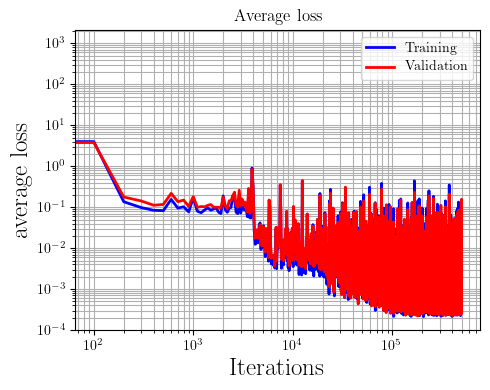

In [15]:
dn.plot_average_loss(loss_file)

### Apply trained model to test data

In [16]:
Load_lowest_loss_model = True

if Load_lowest_loss_model:   
    print('load lowest loss model dictionary: %s' % modelfile)
    modeldict = torch.load(modelfile, map_location=torch.device('cpu'))
    model = NN.HEFTNet()
    model.load_state_dict(modeldict)

# NN-approximated cross sections 
model.eval()
y = model(X).detach().numpy()

# POWHEG-predicted cross sections
t = test_data['sigma'].to_numpy()

load lowest loss model dictionary: heftnet.dict


### Plot NN prediction vs. predicted cross section

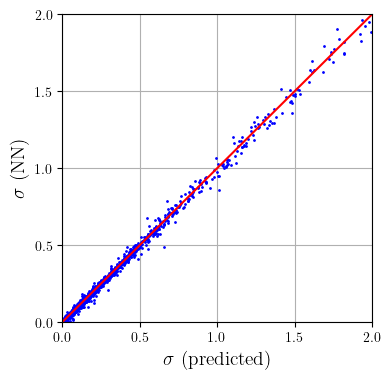

In [17]:
def plot_results(y, t, 
                 xmin=0.0, xmax=2.0, 
                 ymin=0.0, ymax=2.0, 
                 ftsize=14, 
                 filename='figures/fig_results.png'):

    # create an empty figure
    fig = plt.figure(figsize=(4, 4))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows, ncols, index)
    
    ticks = np.linspace(xmin, xmax, 5)
    
    ax.set_xlim(xmin, xmax)
    ax.set_xticks(ticks)
    ax.set_xlabel(r'$\sigma$ (predicted)', fontsize=ftsize)

    ax.set_ylim(ymin, ymax)
    ax.set_yticks(ticks)
    ax.set_ylabel(r'$\sigma$ (NN)', fontsize=ftsize)
    
    ax.plot(y, t, 'b', marker='.', markersize=2, linestyle='')
    ax.plot([xmin, xmax], [ymin, ymax], linestyle='solid', color='red')

    ax.grid(True, which="both", linestyle='-')

    plt.savefig(filename)
    plt.show()

plot_results(y, t)

### Plot coefficients

23


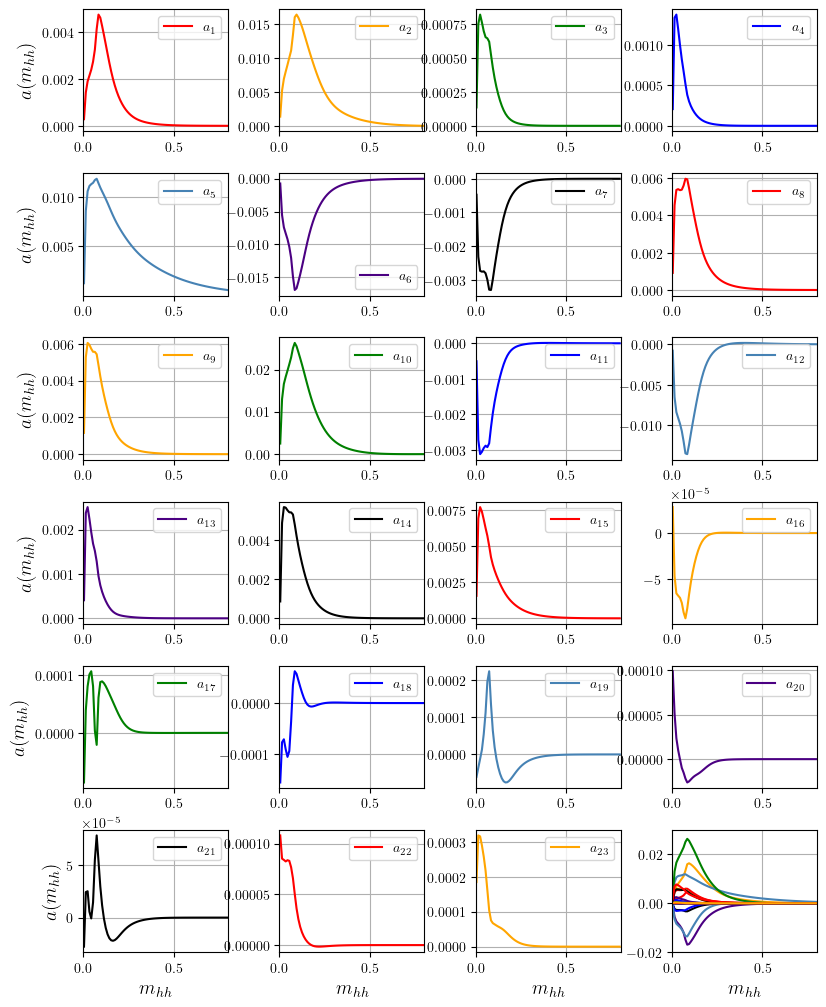

In [18]:
def plot_coeffs(dnn, ftsize=14):
    
    # define equally spaced points for m_hh
    xbins= 80
    xmin = 0
    xmax = xbins/100
    x = np.linspace(xmin, xmax, xbins+1)
    x = (x[1:]+x[:-1])/2

    # detach from computation tree and return coefficients as a numpy array
    a = dnn.coeffs( torch.Tensor(x) ).detach().numpy()
    nplots = len(a[0])
    print(nplots)
    
    # create a mosaic of plots
    # a b c
    # d e f
    # : : :
    # o p p
    # last plot occupies two slots
    fig, axes = plt.subplot_mosaic('abcd;efgh;ijkl;mnop;qrst;uvwy', 
                                   figsize=(8, 10))
    # need the following to make layout look reasonable
    fig.tight_layout()

    # get subplot keys a, b, c, etc.
    keys = list(axes.keys())
    keys.sort()

    kolor = ['red', 'orange', 'green', 'blue', 'steelblue', 'indigo', 'black']

    nrows = 6
    ncols = 4
    
    for i, key in enumerate(keys[:-1]):
        
        ax = axes[key]

        ax.set_xlim(xmin, xmax)
        
        if i > (nrows-1) * ncols-1:
            ax.set_xlabel(r'$m_{hh}$', fontsize=ftsize)
            
        if i % ncols == 0:
            ax.set_ylabel(r'$a(m_{hh})$', fontsize=ftsize)

        # plot (i+1)th coefficient
        y = a.T[i]
        c = kolor[i % len(kolor)]
        index = i + 1
        ax.plot(x, y, color=c, label='$a_{%d}$' % index)
        ax.legend()
        ax.grid()

    # last plot: superimpose all coefficient plots
    ax = axes['y']
    
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$m_{hh}$', fontsize=ftsize)

    ymin = -0.02
    ymax =  0.03
    ax.set_ylim(ymin, ymax)
    
    for i in range(nplots):
        # plot (i+1)th coefficient
        y = a.T[i]
        c = kolor[i % len(kolor)]
        index = i + 1
        ax.plot(x, y, color=c)
    ax.grid()

    plt.savefig('figures/fig_coefficients.png')

plot_coeffs(model)

### Plot spectra

 1. Compute spectra approximated with the NN model.
 2. Compare with POWHEG spectra that have not been used in the training.

In [19]:
def get_spectra(model, df, row):

    # get column names

    columns= list(df.columns)
    #print(columns)
    params = columns[:5]
    #print(params)
    bins   = columns[5:]
    #print(bins)
    
    xbins = len(bins)
    xmin  = 0
    xmax  = xbins/100
    
    # define mhh values
    x = np.linspace(xmin, xmax, xbins+1)
    x = (x[1:]+x[:-1])/2

    # get parameter names
    #print(df[params].iloc[row]) 
    
    klambda, ct, ctt, cggh, cgghh = df[params].iloc[row]

    # create input data
    inputs = []
    for mhh in x:
        inputs.append([mhh, klambda, ct, ctt, cggh, cgghh])

    #print(inputs)    
    # get predicted cross section
    spectrum = df[bins].iloc[row].to_numpy() # predicted spectrum  
    #print(spectrum) 
    
    # get approximated cross section
    inputs = torch.Tensor(np.array(inputs))
    
    model.eval()   
    y = model(inputs).detach().numpy()       # approximated spectrum 

    return spectrum.sum(), x, y, spectrum, klambda, ct, ctt, cggh, cgghh

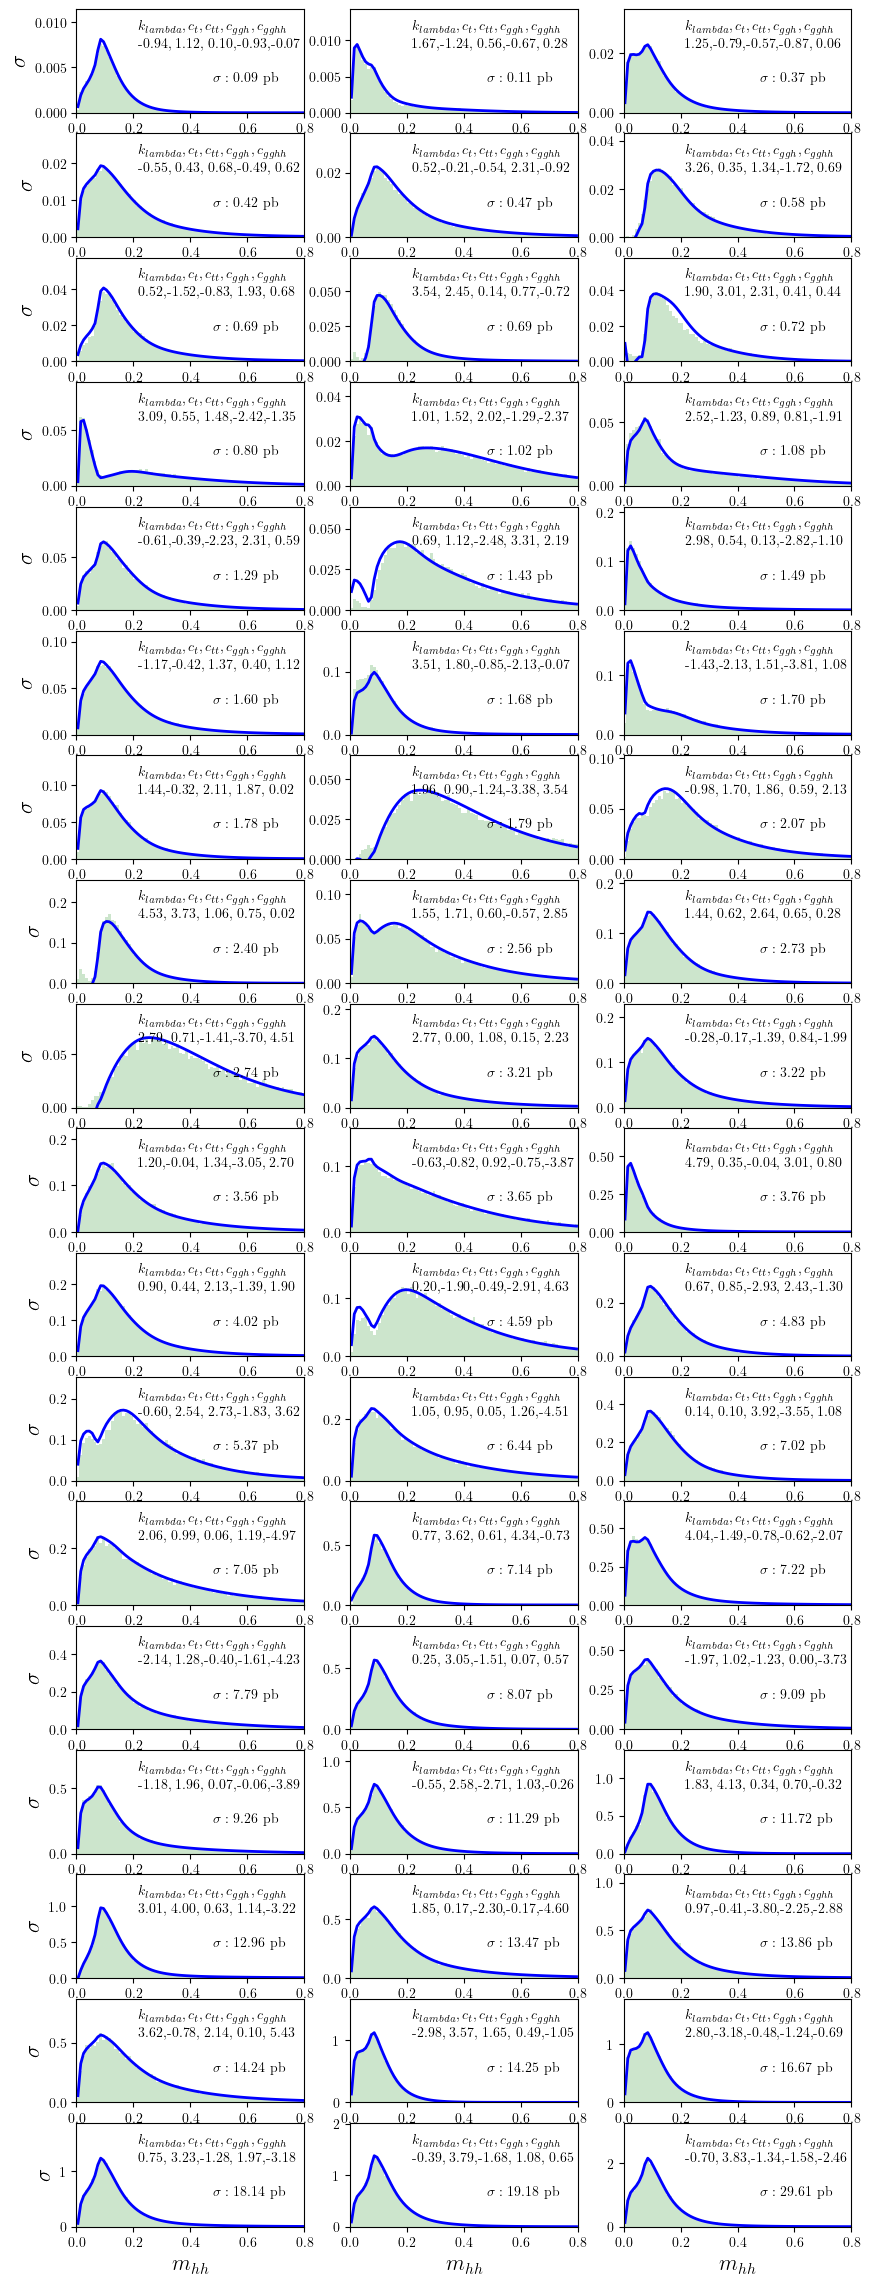

In [20]:
def plot_spectra(data, 
                 ftsize=16, 
                 filename='figures/fig_spectra_comparisons.png'):

    plt.rcParams.update({'font.size': 10})
        
    _, x, y, s, _,_,_,_,_ = data[0]
    #print(data[0])
    xbins = len(x)
    xmin, ymin  = 0, 0
    xmax = xbins/100

    # work out number of columns and number of plots
    ncols = 3
    nrows = len(data) // ncols
    ndata = nrows * ncols
    
    # create an empty figure
    fig = plt.figure(figsize=(10, 1.6*nrows))
    fig.tight_layout()

    # loop over coefficients

    for i, (total_xsec, x, y, f, klambda, ct,ctt, cggh, cgghh) in enumerate(data):

        index = i+1
        ax  = fig.add_subplot(nrows, ncols, index)

        # setup x-axis
        ax.set_xlim(xmin, xmax)
        
        if i > (nrows-1) * ncols-1:
            ax.set_xlabel(r'$m_{hh}$', fontsize=ftsize)

        # setup y-axis
        ymax = 1.5 * f.max()
        ax.set_ylim(ymin, ymax)
        
        if i % ncols == 0:
            ax.set_ylabel(r'$\sigma$', fontsize=ftsize)

        # annotate plot
        xpos = xmin + 0.27 * (xmax-xmin)
        ypos = ymin + 0.80 * (ymax-ymin)
        ystep= (ymax-ymin)/6
        ax.text(xpos, ypos, r'$k_{lambda},c_{t},c_{tt},c_{ggh},c_{gghh}$'); ypos -= ystep
        ax.text(xpos, ypos, '%5.2f,%5.2f,%5.2f,%5.2f,%5.2f' % \
                (klambda, ct, ctt, cggh, cgghh)); ypos -= ystep
        
        xpos = xmin + 0.60 * (xmax-xmin)
        ypos -= ystep
        ax.text(xpos, ypos, r'$\sigma:$ %5.2f pb' % total_xsec)
        
        # predicted spectra
        ax.hist(x, bins=xbins, range=(xmin, xmax), weights=f, 
                    color='green', alpha=0.2)

        # NN-approximated spectra
        ax.plot(x, y, color='blue', linewidth=2)

    plt.savefig(filename)
    plt.show()

# ------------------------------------------------------------------
M = 54
data = []

for row in range(M):
    data.append( get_spectra(model, spectra, row) )

# sort in order of decreasing cross section
data.sort()

plot_spectra(data)